## Imports, Data loading & preprocessing

In [188]:
!pip install hyperopt


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [189]:
import numpy as np 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
import seaborn as sns
import plotly.graph_objects as go
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn.cluster import KMeans
from sklearn import datasets
import statistics as s

In [190]:
def create_batchs(ds):
        batchs = []
        ids = ds.stay_id.unique()
        for i in ids:
            batchs.append(ds.loc[ds['stay_id'] == i])
        return batchs

In [191]:
demographic_batches= np.load('preprocessed_batches/batch_demographic.npy', allow_pickle = True)
demographic = pd.DataFrame(np.load('preprocessed_batches/df_demographic.npy', allow_pickle=True), columns = [ 'id', 'sex', 'age', 'los', 'bmi', 'death', 'gcs'])
df_hourly = pd.read_csv(r'C:\Users\USER\OneDrive\Summer_project\Azure\data\preprocessed_mimic4_hour_std.csv', delimiter=',', index_col = 'stay_id')
df_hourly = df_hourly.pivot_table(index = ['stay_id','hour_from_intime'], columns = 'feature_name', values = 'feature_mean_value')
df_hourly = df_hourly.reset_index(level = 'stay_id')
batches = create_batchs(df_hourly)
df_hourly = df_hourly.drop(columns='stay_id')


(array([278., 181.,  82.,  80.,  49.,  40.,  36.,  26.,  19.,  19.,  20.,
         11.,   9.,  11.,  11.,   6.,   6.,   4.,   3.,   5.,   7.,   1.,
          2.,   4.,   5.,   2.,   2.,   0.,   4.,   0.,   0.,   0.,   0.,
          3.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([2.0063425925925924, 2.955333333333333, 3.904324074074074,
        4.853314814814814, 5.802305555555555, 6.751296296296296,
        7.700287037037036, 8.649277777777776, 9.598268518518518,
        10.547259259259258, 11.496249999999998, 12.445240740740738,
        13.39423148148148, 14.34322222222222, 15.29221296296296,
        16.241203703703704, 17.190194444444444, 18.139185185185184,
        19.088175925925924, 20.037166666666664, 20.986157407407404,
        21.935148148148144, 22.884138888888884, 23.833129629629628,
        24.782120370370368, 25.731111111111108, 26.68010185185185,
        27.62909259259259, 28.57808333333333, 29.527074074074072,
        30.476064814814812, 31.425055555555552, 32.374046296

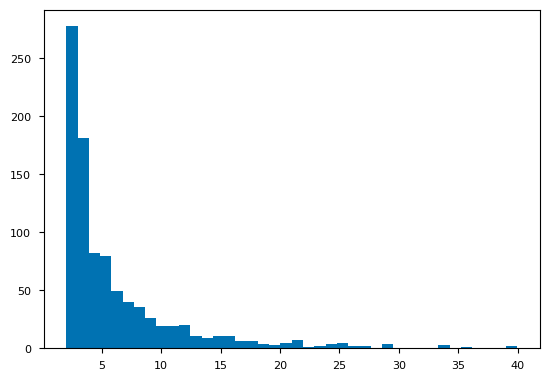

In [192]:
import matplotlib.pyplot as plt
plt.hist(demographic['los'], bins=40)

In [193]:
def label_severity (row):
    if row['gcs'] <8 :
        return "severe"
    if row['gcs'] >= 13 :
        return "mild"
    else:
        return "moderate"

demographic['severity'] = demographic.apply(lambda row: label_severity(row), axis=1)
    

In [194]:
#death rate in tBI severe
print(sum(demographic[demographic.severity == 'severe'].death))

52


## Univariate analysis

[Text(0.5, 1.0, 'Repartition of the TBI severity (GCS) and the corresponding deaths (n = 929)')]

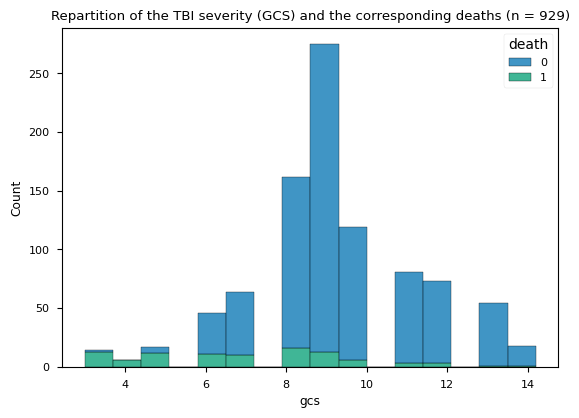

In [195]:
sns.histplot(data = demographic, x = "gcs", hue = "death", multiple="stack", binwidth=0.7).set(title='Repartition of the TBI severity (GCS) and the corresponding deaths (n = 929)')

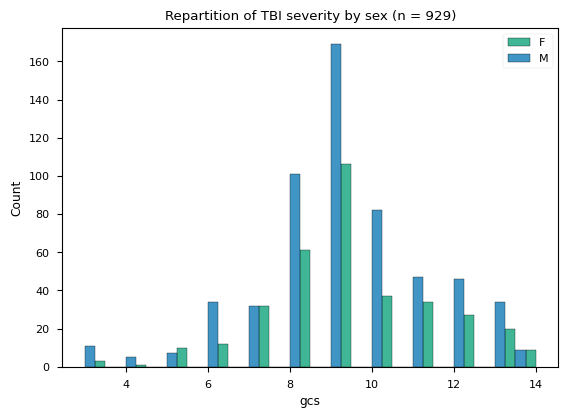

In [196]:
sns.histplot(data = demographic, x = "gcs", hue = "sex", multiple="dodge", binwidth=0.5).set(title='Repartition of TBI severity by sex (n = 929)')
plt.legend(labels = ['F', 'M'])

3.926226851851852


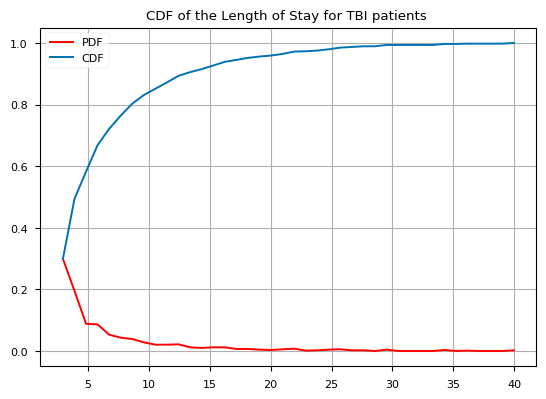

In [197]:
count, bins_count = np.histogram(demographic['los'], bins=40)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.grid()
plt.title('CDF of the Length of Stay for TBI patients ')
print(s.median(demographic['los']))

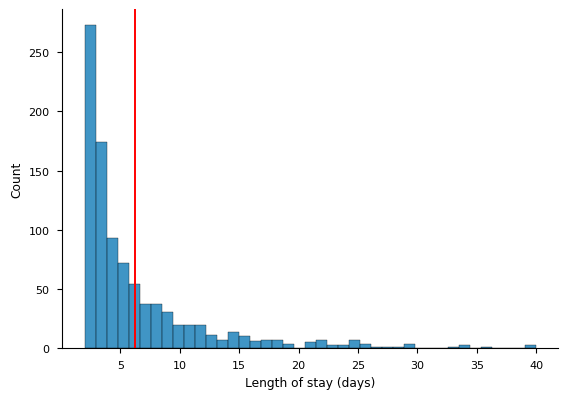

In [198]:
#LOS HIST
fig, ax = plt.subplots()
sns.histplot(data = demographic, x = "los", )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Length of stay (days)')
plt.axvline(x=demographic.los.mean(),
            color='red')

Text(0.5, 0, 'Length of stay (days)')

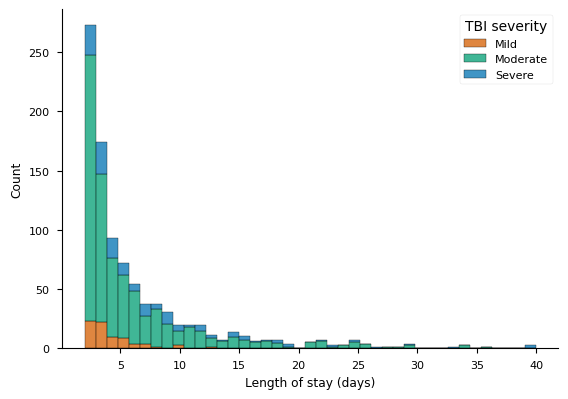

In [199]:
#LOS HIST + SEVERITY 

fig, ax = plt.subplots()
sns.histplot(data = demographic, x = "los", hue = 'severity', multiple = "stack" )
plt.legend(title='TBI severity', labels= ['Mild', 'Moderate', 'Severe'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Length of stay (days)')
          


## Multivariate analysis

In [200]:
fig = go.Figure()
fig.add_trace(go.Box( y = demographic['age'], x= demographic['death'], boxpoints='all'))
fig.update_layout(xaxis_title='Deaths repartition -  0 = stayed alive during the ICU stay, 1 = died during the ICU stay - N = 614', yaxis_title = "Age in years")


[Text(0.5, 1.0, 'Repartition of the TBI severity (GCS) and the corresponding deaths')]

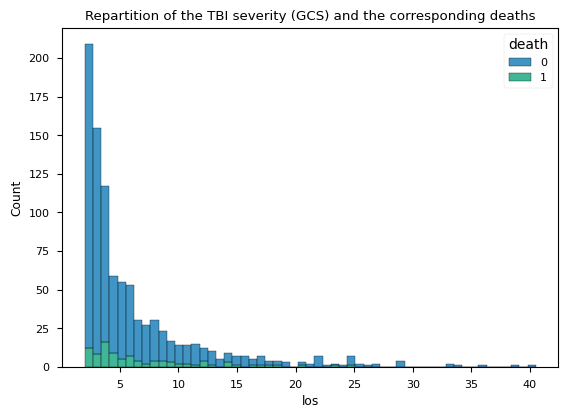

In [201]:
#analysis of death and length of stay 
sns.histplot(data = demographic, x = "los", hue = "death", multiple="stack", binwidth=0.7).set(title='Repartition of the TBI severity (GCS) and the corresponding deaths')


In [202]:
#chi square test 
import scipy.stats as stats
crosstab = pd.crosstab(demographic["gcs"], demographic["death"])
print(stats.chi2_contingency(crosstab))



(259.5330924003164, 2.809866996470494e-49, 11, array([[ 12.56835307,   1.43164693],
       [  5.38643703,   0.61356297],
       [ 15.26157158,   1.73842842],
       [ 41.29601722,   4.70398278],
       [ 57.45532831,   6.54467169],
       [145.43379978,  16.56620022],
       [246.87836383,  28.12163617],
       [106.83100108,  12.16899892],
       [ 72.71689989,   8.28310011],
       [ 65.53498385,   7.46501615],
       [ 48.47793326,   5.52206674],
       [ 16.15931109,   1.84068891]]))


Index(['stay_id', 'ABPd', 'ABPm', 'ABPs', 'HR', 'ICP', 'RR', 'SpO2'], dtype='object', name='feature_name')
          ABPd        ABPm        ABPs          HR  ICP         RR       SpO2
0          NaN         NaN         NaN   73.986486  NaN  15.662162  97.685446
1          NaN         NaN         NaN   74.022388  NaN  22.030303  97.354839
2          NaN         NaN         NaN   87.528053  NaN  24.031509  96.151667
3    87.958274  110.684397  143.103664  115.628324  NaN  19.055233  99.265625
4    61.042735   84.825643  126.849439   85.780445  NaN  22.945557  99.864264
..         ...         ...         ...         ...  ...        ...        ...
924        NaN         NaN         NaN  100.895000  NaN  23.297872  98.189024
925  74.208589   89.308642  109.911043  106.181106  NaN  18.486250  97.033159
926  77.500000  100.150000  138.884615   90.677449  NaN  22.225676  98.057670
927        NaN   -7.500000         NaN   81.452439  NaN  17.285366  96.967073
928        NaN         NaN         

<AxesSubplot:xlabel='HR', ylabel='Count'>

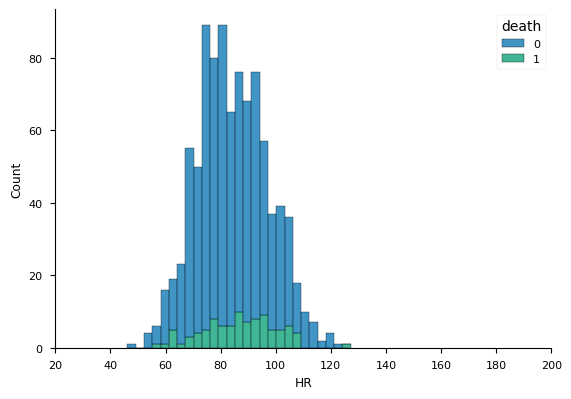

In [203]:
#mean et glascow coma scane
#analysis of death and length of stay 
print(batches[0].columns)
fig, ax = plt.subplots()
plt.rcdefaults() 
plt.style.use(['seaborn-paper', 'seaborn-colorblind'])
means = pd.DataFrame(columns=['ABPd', 'ABPm', 'ABPs', 'HR', 'ICP', 'RR', 'SpO2'])
means.ABPm = [np.mean(batches[i]['ABPm']) for i in range(len(batches))]
means.ABPd = [np.mean(batches[i]['ABPd']) for i in range(len(batches))]
means.ABPs = [np.mean(batches[i]['ABPs']) for i in range(len(batches))]
means.HR = [np.mean(batches[i]['HR']) for i in range(len(batches))]
means.RR = [np.mean(batches[i]['RR']) for i in range(len(batches))]
means.ICP = [np.mean(batches[i]['ICP']) for i in range(len(batches))]
means.SpO2 = [np.mean(batches[i]['SpO2']) for i in range(len(batches))]



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print(means)
plt.xlim(20,200)
sns.histplot(data = demographic, x = means.HR, hue = demographic.death, binwidth=3, multiple="stack")


feature_name  hour_from_intime   ABPd   ABPm    ABPs          HR  ICP  \
74                           1    NaN    NaN     NaN   97.000000  NaN   
141                          1    NaN    NaN     NaN   86.000000  NaN   
344                          1  97.75  122.5  156.25  106.500000  NaN   
726                          1    NaN    NaN     NaN   71.000000  NaN   
1049                         1    NaN    NaN     NaN   89.333333  NaN   
...                        ...    ...    ...     ...         ...  ...   
131545                       1    NaN    NaN     NaN  111.250000  NaN   
131596                       1    NaN    NaN     NaN   95.333333  NaN   
131803                       1    NaN    NaN     NaN   99.500000  NaN   
132100                       1    NaN    NaN     NaN   98.500000  NaN   
132181                       1    NaN    NaN     NaN   91.000000  NaN   

feature_name         RR        SpO2  
74            19.500000   99.000000  
141           21.333333   99.666667  
344      

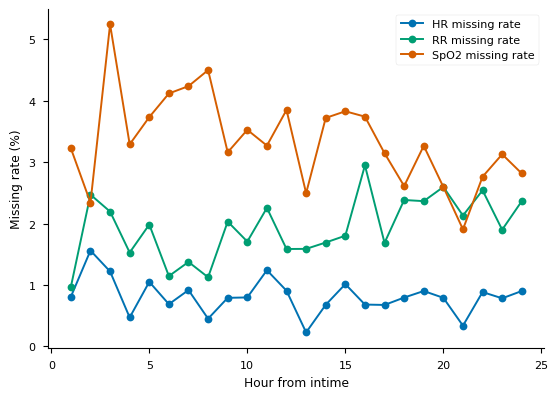

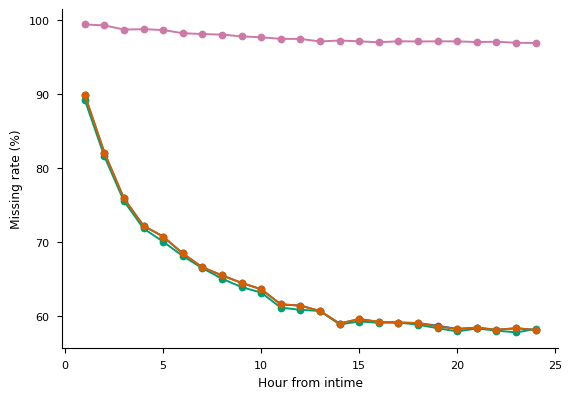

In [248]:
#Missing per hour
# df_hourly = df_hourly.reset_index(level=['hour_from_intime'])
grouped = []
plt.rcdefaults() 
plt.style.use(['seaborn-paper', 'seaborn-colorblind'])
for i in range(1,25):
    grouped.append(df_hourly[df_hourly.hour_from_intime == i])

percent_missing = []
print(grouped[0])
for i in range(1,25):
    percent_missing.append(grouped[i-1].isnull().sum() * 100 / len(grouped[i-1]))

test = np.array(percent_missing)

fig,ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(range(1,25), test[:,[4,6,7]], marker = 'o',label = ['HR missing rate', 'RR missing rate', 'SpO2 missing rate'])
plt.xlabel('Hour from intime')
plt.ylabel('Missing rate (%)')
plt.legend()

fig,ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Hour from intime')
plt.ylabel('Missing rate (%)')
plt.plot(range(1,25), test[:,[1,2,3,5]], marker = 'o', label = ['ABPd missing rate', 'ABPm missing rate', 'ABPs missing rate', 'ICP missing rate'])
plt.legend()

In [205]:
fig = go.Figure()
fig.add_trace(go.Box( y = demographic['gcs'], x= demographic['death'], boxpoints='all', marker_color = 'red'))
fig.update_layout(xaxis_title='Deaths repartition -  0 = stayed alive during the ICU stay, 1 = died during the ICU stay - N = 614', yaxis_title = "Glasgow Coma Scale (GCS)")


In [206]:
fig = go.Figure()
fig.add_trace(go.Box( y = demographic['los'], x= demographic['death'], boxpoints='all', marker_color = 'red'))
fig.update_layout(xaxis_title='Deaths/Los repartition -  0 = stayed alive during the ICU stay, 1 = died during the ICU stay \n N = 614', yaxis_title = "Length of stay")


In [207]:
labels = demographic['los']
print(labels)
labels[labels <= 4] = 0
labels[labels > 4] = 1
print(labels)
print(labels.sum())

0       3.325139
1       2.814954
2       8.457454
3       7.523762
4       8.934433
         ...    
924     2.167859
925     8.703519
926    12.393704
927     3.601539
928     6.632975
Name: los, Length: 929, dtype: object
0      0
1      0
2      1
3      1
4      1
      ..
924    0
925    1
926    1
927    0
928    1
Name: los, Length: 929, dtype: object
455


In [208]:
#age and severity
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()

fig.add_trace(go.Box( y = demographic['age'][demographic['severity'] == "mild"], x = demographic['severity'][demographic['severity'] == "mild"], boxpoints='all', marker_color = 'darkgoldenrod'))
fig.add_trace(go.Box( y = demographic['age'][demographic['severity'] == "moderate"], x = demographic['severity'][demographic['severity'] == "moderate"], boxpoints='all', marker_color = 'indianred'))
fig.add_trace(go.Box( y = demographic['age'][demographic['severity'] == "severe"], x = demographic['severity'][demographic['severity'] == "severe"], boxpoints='all', marker_color = 'lightseagreen'))


fig.update_layout(
    yaxis_title='Age (years)', xaxis_title = 'TBI severity'
 # group together boxes of the different traces for each value of x
)
fig.update(layout_showlegend=False)
fig.show()
# sns.histplot(data = demographic, x = "age", hue = "death", multiple="stack", binwidth=0.7).set(title='Repartition of the TBI severity (GCS) and the corresponding deaths')
